In [6]:
# Autoreload 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Lightning #
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.utilities.rank_zero import rank_zero_only # NEW
from datetime import datetime

# Bacis libraries #
import os   
from dotenv import load_dotenv
load_dotenv('/home/pk21271/keys/key.env')
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Pytorch #
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Personal scripts #
path_src = '../src'
if path_src not in sys.path:
    sys.path.insert(0,path_src)
from preprocessing import *
from callbacks import *
from transformer import AnalysisObjectTransformer, Embedding
from losses import BCEDecorrelatedLoss, CrossEntropyWeightedLoss
from plotting import plot_roc, plot_confusion_matrix


torch.set_float32_matmul_precision('medium')
accelerator = 'gpu' if torch.cuda.is_available() else "cpu"
print (f"Accelerator : {accelerator}")


Accelerator : gpu


# Import datasets

Our files are in parquet files : one for each process, containing all the event level information

The following lines do the import into a pandas dataframe, and the different preprocessing steps we need (remove negative weight events, make labls, split into training and validation sets, etc)

In [7]:
# Make output directory #
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
outdir = f"./model_training/AOTransformer_{current_time}"
os.makedirs(outdir, exist_ok=False)

# Main path
main_path = '/home/pk21271/prep_data/ttH_ttbar_Zjets'

# File paths
x_path = os.path.join(main_path, 'X.pt')
y_path = os.path.join(main_path, 'y.pt')
pad_mask_path = os.path.join(main_path, 'pad_mask.pt')
reweighting_path = os.path.join(main_path, 'reweighting.pt')
weight_nom_path = os.path.join(main_path, 'weight_nom.pt')
event_level_path = os.path.join(main_path, 'event_level.pt')

# Load data
X = torch.load(x_path)
y = torch.load(y_path)
pad_mask = torch.load(pad_mask_path)
reweighting = torch.load(reweighting_path)
weight_nom = torch.load(weight_nom_path)
event_level = torch.load(event_level_path)

## Create training datasets ## Also added the nominal weights
train_X, val_X, train_y, val_y, train_weights, val_weights, train_mask, val_mask, train_event, val_event, train_nom, val_nom = train_test_split(
    X, 
    y, 
    reweighting, 
    pad_mask, 
    event_level,
    weight_nom, 
    test_size=0.2,  
    random_state=42,
)

train_dataset = TensorDataset(train_X, train_y, train_weights, train_mask, train_event)
valid_dataset = TensorDataset(val_X, val_y, val_weights, val_mask, val_event)

## Create loaders ##
batch_size = 1024

train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size = batch_size, 
    shuffle = True,
    num_workers = 11, 
)
valid_loader = DataLoader(
    dataset = valid_dataset, 
    batch_size = 10000, # can use larger batches for the GPU 
    shuffle = False, 
    num_workers = 11,
)
# NOTE : in a jupyter notebook it is not possible to use `num_workers` dues to multiprocessing issues.
# Use this notebook for testing and experimenting, but to benefit from multiprocessing batch loading, you will need the python scripts

/tmp/ipykernel_1756836/3595201848.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load(x_path)
/tmp/ipykernel_1756836/3595201848.py:19: FutureWarning: You are

# Input plots 

Always a good idea to check the inputs you provide in the training. It is very easy to introduce incorrect data in the training, and then spend hours investigating the problem in the model, only to find the data is nonsensical (the good old "garbage in, garbage out" syndrom).

The plotting scripts below show the inputs features (ie, jet features) as a function of the multiplicity and labels.
- var 0 : $p_T$
- var 1 : $\eta$
- var 2 : $\phi$
- var 3 : mass
- var 4 : area


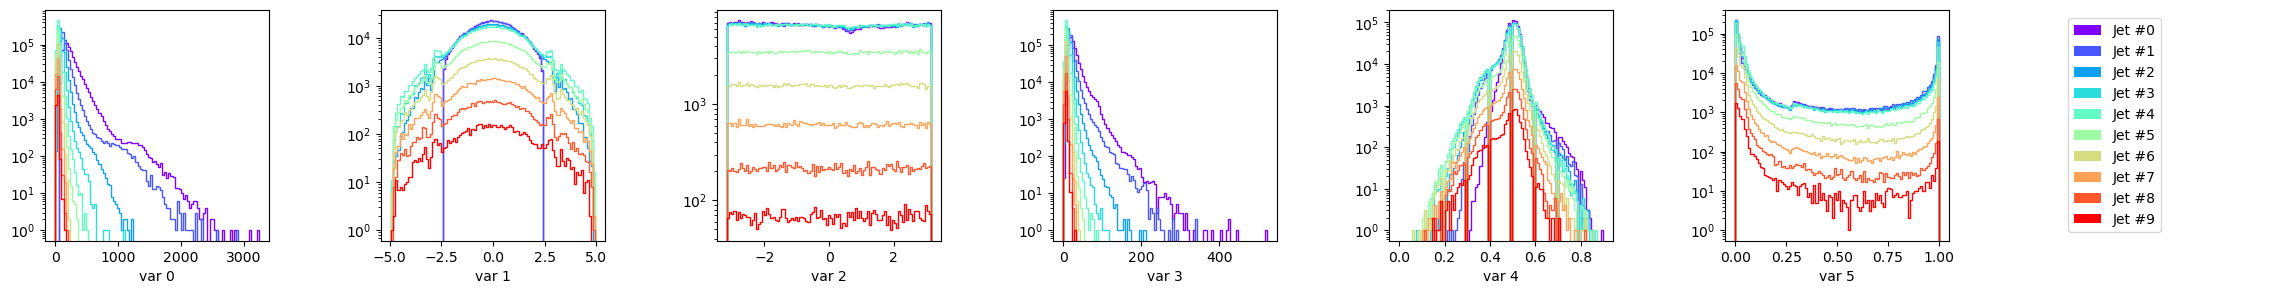

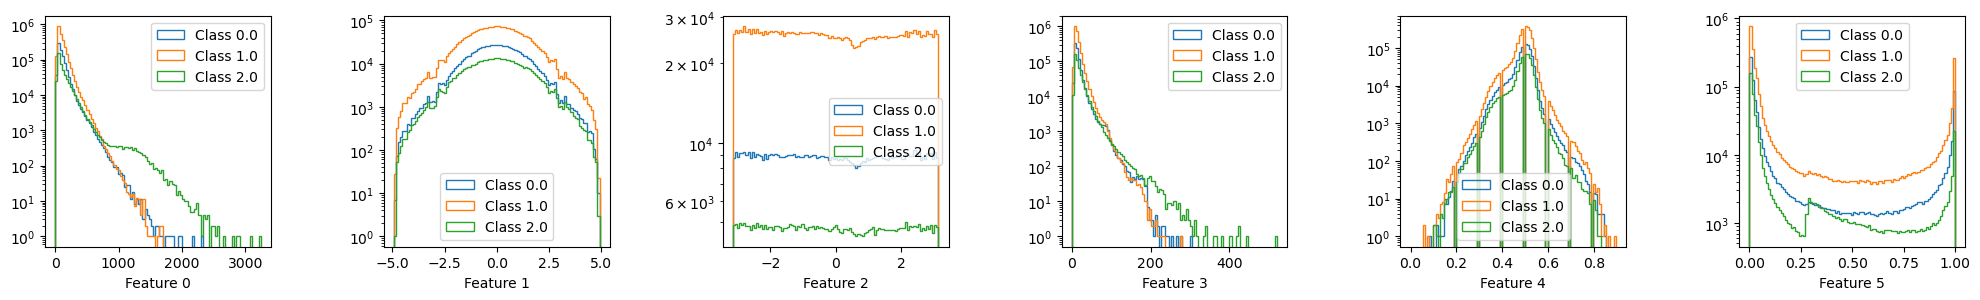

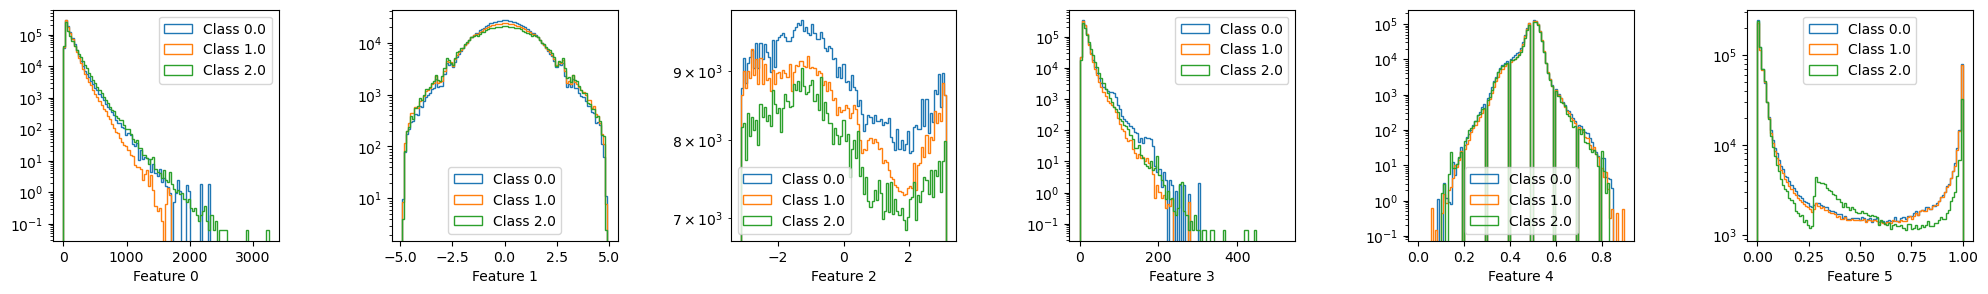

In [8]:
fig = plot_inputs_per_multiplicity(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label_multi(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label_multi(X,y,pad_mask,bins=100,weights=reweighting,log=True,show=True)

# Model
The transformer model can be tweaked with the parameters below (see explanations for each parameter.

The loss function is a composite of BCE, and decorrelation from the MET, to ensure the transformer does not sculpt the latter.

In [ ]:
# Define model #
loss_function = CrossEntropyWeightedLoss(weighted = True)

# loss = BCE + lambda * decorrelated loss # Lambda determines the strength of the decorrelation loss
# lambda = 0 -> pure BCE

# Embedding of the jet features into a higher dimension
embedding = Embedding(
    input_dim = train_X.shape[-1],   # Input dimension
    embed_dims = [64],               # Output dimension
    normalize_input = True,          # Whether to apply batch norm before the embedding
)

output_dim = len(torch.unique(y)) if len(torch.unique(y)) > 2 else 1
print(output_dim)

# Choose number of layers
enc = 5
cla = 3
dnn = 3

model = AnalysisObjectTransformer(
    embedding = embedding,           # Embedding instance 
    embed_dim = embedding.dim,       # Embedding dimension
    num_heads = 8,                   # Number of heads for multihead attention (must be a divisor of embed dim) 
    output_dim = output_dim,         # Output dimension (1 : binary classification, >1 : multi classification) 
    expansion_factor = 4,            # Multipliying factor for layers in attention block (neurons = embed_dim * expansion_factor) norm is 4
    encoder_layers = enc,              # Number of encoder layers (self attention on jets)
    class_layers = cla,                # Number of class layers (cross attention between jets representations and class token)
    dnn_layers = dnn,                  # Number of layers for DNN after the transformer
    hidden_activation = nn.GELU,     # Hidden activation in transformer and DNN
    output_activation = None,        # DNN output activation (sigmoid for binary, softmax for multiclass, None if applied in the loss)
    dropout = 0.2,                   # Dropout rate - default was 0.1
    loss_function = loss_function,   # Loss function, see above
)

# Print the model graph #
print (model)
# Quick benchmark test the model #
# To make sure the model will run, we take a single batch from the training and pass it through the model

batch = next(iter(train_loader))

inputs, labels, weights, mask, event = batch
print ('Batch dtypes',inputs.dtype,labels.dtype,weights.dtype,mask.dtype,event.dtype)

outputs = model(inputs,padding_mask=mask)
print ('outputs',outputs .shape)
loss_values = loss_function(outputs,labels,event,weights)
print ('losses',loss_values)

3
AnalysisObjectTransformer(
  (embedding): Embedding(
    (input_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (encoder_blocks): ModuleList(
    (0-4): 5 x AttBlock(
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layer_norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (class_blocks):

# Training 

Writing the training loop can involve a biut of boilerplate code. To bypass that we use the [pytorch-lightning](https://lightning.ai/docs/pytorch/stable/) package to run the training. 

The batch steps were defined in the model class, and now we can use the trainer class from lightning to run the training. This takes care of doing the loop, putting data on the GPU if needed, applying the schedule, etc.

One way to finetune our training (or monitor it) is through callbacks. Callbacks are class objects that are evaluated at different times during the training, and allow the user to access their model. Below we use a few of those :
- model checkpoint : saves the best model parameters at every epoch
- early stopping : if the loss values (of the validation) plateau, stops the training (hopefully before overtraining)
- plotting : a plotting callback we wrote to plot the classification metrics at every epoch
- a few other tweaks

Lighting also allows several plotter interface, we use `comet` to log all our metrics (and callback plots) online. You will need an account [here](https://www.comet.com/signup), you can use your github account if you want.

In [ ]:
##### Parameters #####

# Choose max epochs and learning rate
epochs = 150
# lr = 1e-4
lr = 5e-4

print(len(train_dataset), len(valid_dataset))

steps_per_epoch_train = math.ceil(len(train_dataset)/train_loader.batch_size)
steps_per_epoch_valid = math.ceil(len(valid_dataset)/valid_loader.batch_size)

print (f'Training   : Batch size = {train_loader.batch_size} => {steps_per_epoch_train} steps per epoch')
print (f'Validation : Batch size = {valid_loader.batch_size} => {steps_per_epoch_valid} steps per epoch')

# Setup optimizer #
optimizer = optim.Adam(model.parameters(), lr=lr)
model.set_optimizer(optimizer)

# Setup scheduler #
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
   optimizer = optimizer,
   mode = 'min', 
   factor = 0.2, 
   patience = 4, #Was 10
   threshold = 0., 
   threshold_mode = 'rel', 
   cooldown = 0, 
   min_lr = 1e-8,
)

model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'lr',
    }
)

# Setup callbacks #
checkpoint_callback = ModelCheckpoint(
    dirpath=outdir,  # Directory where checkpoints will be saved
    filename="best-checkpoint",  # Checkpoint filename
    monitor="val/loss_tot",  # Monitor validation loss
    mode="min",  # Save the best model with the minimum validation loss
    save_top_k=1  # Save only the best model
)

early_stopping = EarlyStopping(
    monitor='val/loss_tot',  # Metric to monitor
    patience=8,          # Number of epochs with no improvement after which training will be stopped #Defacult was 30, changed to 8
    verbose=True,
    mode='min'           # 'min' for loss, 'max' for accuracy
)

log_bar = L.pytorch.callbacks.TQDMProgressBar(refresh_rate=steps_per_epoch_train//100)

plots_callback = EpochEndCallback(
    data = valid_loader,
    frequency = 1,
    subcallbacks = [
        ScoreSubCallback(name='score',bins=100,log=True),
        CorrelationSubCallback(name='corr',bins=100,log=True),
        ROCSubCallback(name='ROC'),
        ConfusionMatrixSubCallback(name='CM'),
    ]
)

## Logger ##
# logger = CometLogger(
#     api_key = os.environ.get("COMET_API_KEY"), 
#     project_name = "AnalysisObjectTransformer",
#     experiment_name = "Setup",
#     save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
#     offline = False  # Set to True for offline mode


## Logger ## (THIS IS THE NEW ONE WITH THE PATH SETUP)
logger = CometLogger(
    api_key = os.getenv("COMET_API_KEY"),
    project_name = "AnalysisObjectTransformer",
    experiment_name = f"{enc},{cla},{dnn} | lr={lr}",
    save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
    offline = False  # Set to True for offline mode
)

## Trainer ##
trainer = L.Trainer(
    strategy = "ddp_notebook",
    default_root_dir = outdir,
    accelerator = accelerator,
    devices = [0,1,2,3],  # Use only one GPU
    max_epochs = epochs,  # Specify the number of epochs
    log_every_n_steps = steps_per_epoch_train, # This is logging the wrong number
    check_val_every_n_epoch = 1,  # Check validation every n epochs
    callbacks = [  # Remove the plotting callbacks 
        early_stopping,
        log_bar,
    ],
    logger = logger,
    # limit_train_batches = 10,
    # limit_val_batches = 1,
    # limit_test_batches = 1,
)

trainer.fit(
    model = model, 
    train_dataloaders = train_loader, 
    val_dataloaders = valid_loader,
)
trainer.save_checkpoint(f"{outdir}/model.pt")

527070 131768
Training   : Batch size = 1024 => 515 steps per epoch
Validation : Batch size = 10000 => 14 steps per epoch


CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.c

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (129) is smaller than the logging interval Trainer(log_every_n_steps=515). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved. New best score: 0.595
[rank: 1] Metric val/loss_tot improved. New best score: 0.595
[rank: 3] Metric val/loss_tot improved. New best score: 0.595
[rank: 2] Metric val/loss_tot improved. New best score: 0.595


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.020 >= min_delta = 0.0. New best score: 0.574
[rank: 2] Metric val/loss_tot improved by 0.020 >= min_delta = 0.0. New best score: 0.574
[rank: 3] Metric val/loss_tot improved by 0.020 >= min_delta = 0.0. New best score: 0.574
[rank: 1] Metric val/loss_tot improved by 0.020 >= min_delta = 0.0. New best score: 0.574


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 0.569
[rank: 2] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 0.569
[rank: 3] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 0.569
[rank: 1] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 0.569


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.024 >= min_delta = 0.0. New best score: 0.545
[rank: 3] Metric val/loss_tot improved by 0.024 >= min_delta = 0.0. New best score: 0.545
[rank: 1] Metric val/loss_tot improved by 0.024 >= min_delta = 0.0. New best score: 0.545
[rank: 2] Metric val/loss_tot improved by 0.024 >= min_delta = 0.0. New best score: 0.545


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 0.537
[rank: 1] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 0.537
[rank: 2] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 0.537
[rank: 3] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 0.537


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 0.529
[rank: 2] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 0.529
[rank: 3] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 0.529
[rank: 1] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 0.529


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 0.518
[rank: 1] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 0.518
[rank: 2] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 0.518
[rank: 3] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 0.518


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 0.509
[rank: 1] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 0.509
[rank: 2] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 0.509
[rank: 3] Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 0.509


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 0.504
[rank: 1] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 0.504
[rank: 3] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 0.504
[rank: 2] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 0.504


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.501
[rank: 2] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.501
[rank: 3] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.501
[rank: 1] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.501


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.497
[rank: 1] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.497
[rank: 3] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.497
[rank: 2] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.497


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 0.491
[rank: 1] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 0.491
[rank: 2] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 0.491
[rank: 3] Metric val/loss_tot improved by 0.006 >= min_delta = 0.0. New best score: 0.491


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.489
[rank: 2] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.489
[rank: 1] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.489
[rank: 3] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.489


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 0.484
[rank: 1] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 0.484
[rank: 2] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 0.484
[rank: 3] Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 0.484


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 0.484
[rank: 1] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 0.484
[rank: 3] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 0.484
[rank: 2] Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 0.484


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.482
[rank: 1] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.482
[rank: 3] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.482
[rank: 2] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.482


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 0.481
[rank: 1] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 0.481
[rank: 2] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 0.481
[rank: 3] Metric val/loss_tot improved by 0.001 >= min_delta = 0.0. New best score: 0.481


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Monitored metric val/loss_tot did not improve in the last 8 records. Best score: 0.481. Signaling Trainer to stop.
[rank: 1] Monitored metric val/loss_tot did not improve in the last 8 records. Best score: 0.481. Signaling Trainer to stop.
[rank: 2] Monitored metric val/loss_tot did not improve in the last 8 records. Best score: 0.481. Signaling Trainer to stop.
[rank: 3] Monitored metric val/loss_tot did not improve in the last 8 records. Best score: 0.481. Signaling Trainer to stop.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : 5,2,3|lr=0.0005
COMET INFO:     url                   : https://www.comet.com/inigostibbe/analysisobjecttransformer/27d521301d6845c3a4b4b24262c29b0d
COMET INF

In [11]:
## Testing model performance on validation set ##
single_gpu_trainer = L.Trainer(accelerator="gpu", devices=1)
preds = single_gpu_trainer.predict(model=model, dataloaders=valid_loader)
preds = torch.cat(preds, dim=0)

inputs, labels, weights, mask, event = valid_dataset.tensors

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]


Predicting: |          | 0/? [00:00<?, ?it/s]

# Metrics

In [12]:
probs = torch.softmax(preds, dim=1)  # Converts logits to probabilities
predicted_classes = np.argmax(probs, axis=1)
wn = np.array((val_nom * 200000).flatten())

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

print(classification_report(labels, predicted_classes, target_names=["ttH", "ttBar", "Zjets"], sample_weight=wn)) 

              precision    recall  f1-score   support

         ttH       0.09      0.64      0.16 390.67675755970413
       ttBar       0.94      0.67      0.78 10336.93831325043
       Zjets       0.56      0.69      0.62 2192.665889885131

    accuracy                           0.67 12920.280960695265
   macro avg       0.53      0.67      0.52 12920.280960695265
weighted avg       0.85      0.67      0.73 12920.280960695265



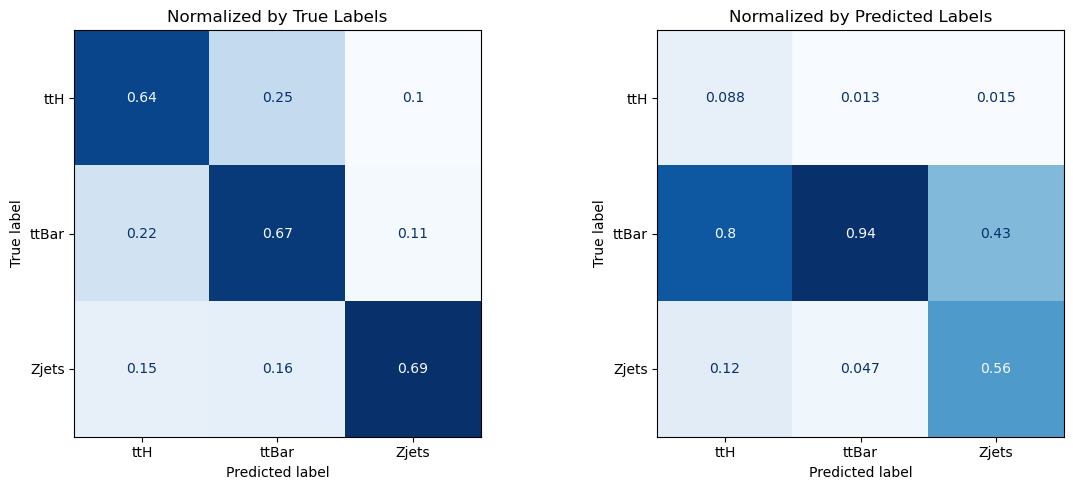

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrices first (avoid multiple calls to .plot())
cm_true = confusion_matrix(labels, predicted_classes, normalize="true", sample_weight=wn)
cm_pred = confusion_matrix(labels, predicted_classes, normalize="pred", sample_weight=wn)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot "True" normalized confusion matrix on the first axis
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_true, display_labels=["ttH", "ttBar", "Zjets"])
disp1.plot(ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
axes[0].set_title("Normalized by True Labels")

# Plot "Pred" normalized confusion matrix on the second axis
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_pred, display_labels=["ttH", "ttBar", "Zjets"])
disp2.plot(ax=axes[1], cmap=plt.cm.Blues, colorbar=False)
axes[1].set_title("Normalized by Predicted Labels")

# Adjust layout and show
plt.tight_layout()
plt.show()


In [19]:
# Plot normalized confusion matrix
# ConfusionMatrixDisplay.from_predictions(labels, predicted_classes, normalize="true", display_labels=["ttH", "ttBar", "Zjets"], cmap=plt.cm.Blues, sample_weight=wn)
# ConfusionMatrixDisplay.from_predictions(labels, predicted_classes, normalize="pred", display_labels=["ttH", "ttBar", "Zjets"], cmap=plt.cm.Blues, sample_weight=wn)

# plt.show()

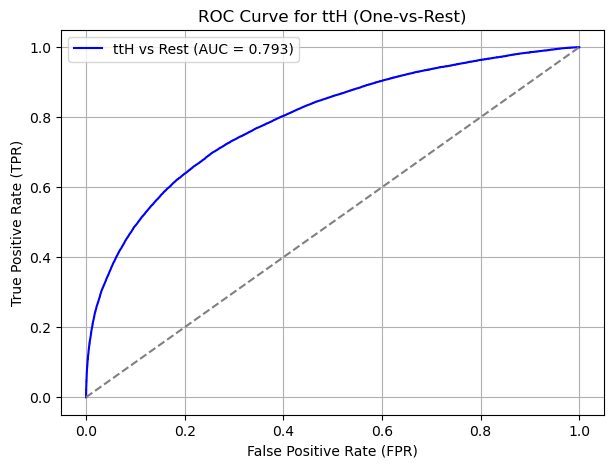

In [18]:
# Plot the ROC AUC score for the ttH one vs all 

from sklearn.metrics import roc_curve, auc

# Convert labels to binary for one-vs-rest (ttH = 1, others = 0)
binary_labels = (labels == 0).to(torch.int)

# Extract predicted probabilities for the ttH class
ttH_probs = probs[:, 0]  # First column corresponds to ttH

# Compute ROC curve
fpr, tpr, _ = roc_curve(binary_labels, ttH_probs)

# Compute AUC score
auc_score = roc_auc_score(binary_labels, ttH_probs)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', label=f"ttH vs Rest (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line (random chance)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for ttH (One-vs-Rest)")
plt.legend()
plt.grid()
plt.show()


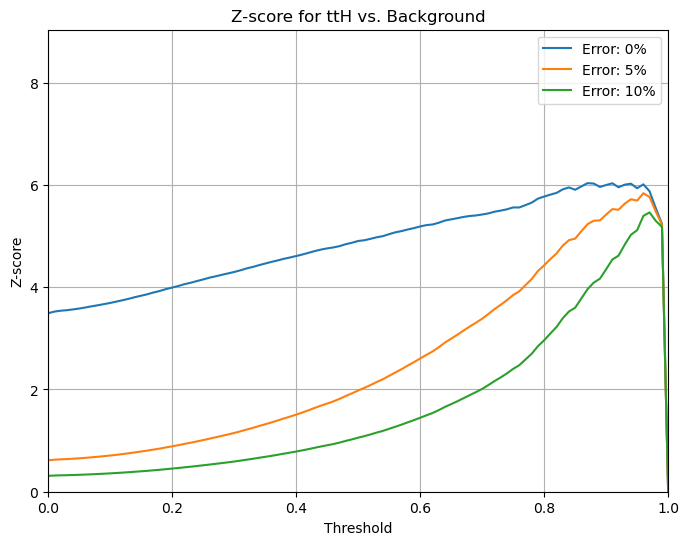

In [105]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Assume preds, labels, and val_nom are already defined
# preds: Softmax output probabilities (shape: [samples, 3]) for 3 classes
# labels: True labels (0=ttH, 1=ttBar, 2=Zjets)
# val_nom: Event weight scaling factor

# Weights array
wn = np.array((val_nom * 200000).flatten())  # Weight nominal

probs_flat = np.array(probs[:, 0].flatten())  # Take softmax output for ttH

# Convert labels: ttH (0) → 1 (signal), Others (1,2) → 0 (background)
binary_labels = np.where(labels == 0, 1, 0)

# Define threshold range
thresholds = np.linspace(0, 1, 101)

# Define systematic uncertainty levels
error_levels = [0.0, 0.05, 0.10]  # 0%, 5%, 10%
z_scores_dict = {err: [] for err in error_levels}

# Compute Z-score at different thresholds
for threshold in thresholds:
    # Weighted Signal (S): Sum of weights where ttH is predicted above threshold
    S = np.sum(wn[(probs_flat > threshold) & (binary_labels == 1)])  # True ttH predictions

    # Weighted Background (B): Sum of weights where background (ttBar, Zjets) is predicted above threshold
    B = np.sum(wn[(probs_flat > threshold) & (binary_labels == 0)])

    for err in error_levels:
        sig_B = B * err  # Apply systematic uncertainty
        Z = S / np.sqrt(B + sig_B**2 + 1e-10)  # Avoid division by zero
        z_scores_dict[err].append(Z)

# Plot Z-score vs. Threshold for different systematic uncertainties
plt.figure(figsize=(8, 6))
for err, z_scores in z_scores_dict.items():
    plt.plot(thresholds, z_scores, label=f"Error: {int(err*100)}%")

plt.xlabel("Threshold")
plt.ylabel("Z-score")
plt.title("Z-score for ttH vs. Background")
plt.grid()
plt.ylim(0, max(max(z_scores) for z_scores in z_scores_dict.values()) + 3)
plt.xlim(0, 1)
plt.legend()
plt.show()
